In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import module

In [2]:
# define tickers of stocks that are to be analyzed
tickers = [ \
    'AAPL', # Apple
    'MSFT', # Microsoft
    'AMZN', # Amazon
    '^GSPC'] # S&P500 - Benchmark

# define time span of stock price data
start_date = '2010-01-01'
end_date = '2021-12-31'
    
# download the data
df_prices, df_price_changes = module.download_stock_price_data(tickers, start_date, end_date)

[*********************100%***********************]  4 of 4 completed


In [ ]:
# DEFINE THREE TRADING SIGNALS

# DO YOUR RESEARCH IN A SEPARATE NOTEBOOK AND IMPLEMENT THE FINAL SIGNALS IN THE MODULE
# PLEASE PROVIDE THE FOLLOWING AS PART OF THE ASSESSMENT:
# - provide a reference to the related literature for each trading signal as mentioned below
# - provide your SEPARATE RESERACH NOTEBOOK in which you back your trading signals
#   and their parameters by empirical research:
#   - perform a systematic parameter search / optimization that backs your parameter selection empirically
#   - perform extensive in-sample and out-of-sample testing of your trading signals and parameters with respect to
#   -- companies / stocks
#   -- time horizons
#   - there is no example for your research notebook, you're completely free to develop it according to your research
# - provide a module.py file to re-use your code in both your assessment notebook and your research notebook

# REMEMBER THAT YOU MAY NOT USE BUILT-IN FUNCTIONS FROM OTHER LIBRARIES THAN NUMPY
# WHEN IN DOUBT - CODE A FUNCTION IN NUMPY ON YOUR OWN!
# EXAMPLE: .rolling().mean() is a built-in function in Pandas, that's why moving average is implemented in NumPy (see module.py)

# PLEASE MAKE SURE THAT YOUR SIGNAL FUNCTIONS DO NOT GENERATE
# A SELL SIGNAL WHEN THERE WAS NO BUY SIGNAL

Signal 0 is a moving average signal. It is active when the following condition is met in $t$:

$\frac{1}{250}\sum\limits^{249}_{i=0}p_{t-i}>\frac{1}{500}\sum\limits^{499}_{i=0}p_{t-i}$

In [3]:
### SIGNAL 0
def signal_0(series):
    return module.ma_signal(series, 250, 500)

Signal 1 is a moving average signal. It is active when the following condition is met in $t$:

$\frac{1}{125}\sum\limits^{124}_{i=0}p_{t-i}>\frac{1}{250}\sum\limits^{249}_{i=0}p_{t-i}$

In [4]:
### SIGNAL 1
def signal_1(series):
    return module.ma_signal(series, 125, 250)

Signal 2 is a moving average signal. It is active when the following condition is met in $t$:

$\frac{1}{60}\sum\limits^{59}_{i=0}p_{t-i}>\frac{1}{120}\sum\limits^{119}_{i=0}p_{t-i}$

In [5]:
### SIGNAL 2
def signal_2(series):
    return module.ma_signal(series, 60, 120)

In [6]:
# Compute signals
signals = {
    tickers[0]: signal_0(df_prices[tickers[0]]),
    tickers[1]: signal_1(df_prices[tickers[1]]),
    tickers[2]: signal_2(df_prices[tickers[2]])}
df_position_open = pd.concat([
    signals[tickers[0]]['signal'].rename(tickers[0]),
    signals[tickers[1]]['signal'].rename(tickers[1]),
    signals[tickers[2]]['signal'].rename(tickers[2])], axis = 1)
df_position_changes = pd.concat([
    signals[tickers[0]]['position_change'].rename(tickers[0]),
    signals[tickers[1]]['position_change'].rename(tickers[1]),
    signals[tickers[2]]['position_change'].rename(tickers[2])], axis = 1)

            signal   short_ma    long_ma
Date                                    
2010-01-04     0.0   3.505423   3.897071
2010-01-05     0.0   3.535109   3.916526
2010-01-06     0.0   3.564999   3.935914
2010-01-07     0.0   3.596095   3.955724
2010-01-08     0.0   3.627122   3.975638
...            ...        ...        ...
2021-12-23     0.0  77.506135  70.259601
2021-12-27     0.0  76.978542  69.992918
2021-12-28     0.0  76.444882  69.729786
2021-12-29     0.0  75.908755  69.468898
2021-12-30     0.0  75.371415  69.210019

[3020 rows x 3 columns]
            signal    short_ma     long_ma
Date                                      
2010-01-04     0.0   10.759519   10.239786
2010-01-05     0.0   10.829969   10.282429
2010-01-06     0.0   10.902084   10.325164
2010-01-07     0.0   10.975652   10.368007
2010-01-08     0.0   11.049553   10.411017
...            ...         ...         ...
2021-12-23     0.0  154.468838  135.619201
2021-12-27     0.0  153.429039  135.185966
2021-12-28  

In [7]:
# ALLOCATE CAPITAL AND COMPUTE RESULTING POSITIONS
initial_cash = 1.0
capital_fraction_per_trade = 0.2

# DO NOT MODIFY THIS CELL BELOW THIS LINE
position = []

def open_trades(position, position_change):
    vec = np.maximum([position_change[ticker] for ticker in tickers[:-1]], [0])
    vec = position[-1] * (1 - np.power((1 - capital_fraction_per_trade), np.sum(vec))) * vec / (1 if (np.nansum(vec) == 0.0) else np.nansum(vec))
    return np.append(vec + position[:-1], position[-1] - np.sum(vec))

def hold_trades(position, price_change):
    return np.concatenate((position[:-1] * price_change[:-1], [position[-1]]))

def close_trades(position, position_change):
    vec = np.concatenate((np.array([position_change[ticker] < 0.0 for ticker in tickers[:-1]]), [False]))
    position[-1] = position[-1] + np.sum(position[vec])
    position[vec] = 0.0
    return position
    
is_first = True
for idx, position_change in df_position_changes.iterrows():
    if is_first:
        position.append(open_trades(np.concatenate((np.zeros(len(df_position_changes.columns)), [initial_cash])), position_change))
        is_first = False
    else:
        hlpr_pos = hold_trades(position[-1], df_price_changes.loc[[idx]].to_numpy()[0])
        hlpr_pos = close_trades(hlpr_pos, position_change)
        position.append(open_trades(hlpr_pos, position_change))

df_position = pd.DataFrame(position, index = df_prices.index, columns = tickers[:-1] + ['cash'])

In [8]:
# COMPUTE MEANINGFUL STATISTICS OF YOUR STRATEGY
# YOU ARE FREE TO CHOOSE MEASURES

# REMEMBER THAT YOU MAY NOT USE READY-TO-USE FUNCTIONS FROM OTHER LIBRARIES THAN NUMPY
# WHEN IN DOUBT - CODE A FUNCTION ON YOUR OWN!
# EXAMPLE: .mean() and .std() are ready-to-use, that's why they are implemented using NumPy below

returns = df_position.sum(axis=1)
returns = (returns[1:].to_numpy() / returns[:-1].to_numpy()) - 1
mean_returns = np.sum(returns) / len(returns)
std_returns = np.sqrt(np.sum(np.square(returns - mean_returns)) / len(returns))
print('Annualized mean: ' + str(mean_returns * 250))
print('Annualized std:  ' + str(std_returns * np.sqrt(250)))

Annualized mean: 0.05491076744177668
Annualized std:  0.06464266644789518


<Axes: xlabel='Date'>

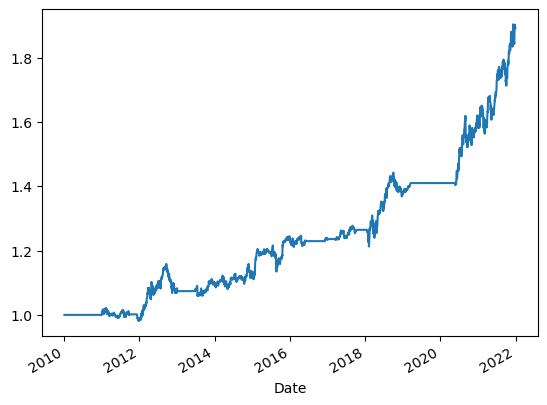

In [9]:
# COMPUTE MEANINGFUL PLOTS OF YOUR STRATEGY AND LABEL THEM IN AN UNDERSTANDABLE WAY
df_position.sum(axis=1).plot()